In [1]:
import pandas as pd
import json

# 加载 CSV 文件
csv_file_path = '../data/speed_data_data.csv'
csv_data = pd.read_csv(csv_file_path)

# 加载 JSON 文件
json_file_path = '../data/career.json'
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

# 创建一个映射字典来将 JSON 文件中的数据转换为 DataFrame
career_mapping = {}
for category, careers in json_data.items():
    for career in careers:
        career_mapping[career.lower()] = category

# 删除包含缺失值的行
csv_data.dropna(inplace=True)

# 将 CSV 文件中的 'career' 列替换为 JSON 文件中的对应类别
def map_career_to_category(career):
    if isinstance(career, str):
        return career_mapping.get(career.lower(), 'Unknown')
    return 'Unknown'

csv_data['career'] = csv_data['career'].apply(map_career_to_category)

print("\nUpdated CSV Data:")
print(csv_data.head())



Updated CSV Data:
   gender   age   income  goal  career  dec  attr  sinc  intel  fun  amb  \
0       0  21.0  69487.0   2.0  lawyer    1   6.0   9.0    7.0  7.0  6.0   
1       0  21.0  69487.0   2.0  lawyer    1   7.0   8.0    7.0  8.0  5.0   
3       0  21.0  69487.0   2.0  lawyer    1   7.0   6.0    8.0  7.0  6.0   
4       0  21.0  69487.0   2.0  lawyer    1   5.0   6.0    7.0  7.0  6.0   
5       0  21.0  69487.0   2.0  lawyer    0   4.0   9.0    7.0  4.0  6.0   

   shar  like  prob  met  
0   5.0   7.0   6.0  2.0  
1   6.0   7.0   5.0  1.0  
3   8.0   7.0   6.0  2.0  
4   6.0   6.0   6.0  2.0  
5   4.0   6.0   5.0  2.0  


### Part 1. 决策树模型（CART）

Accuracy: 0.7674750356633381
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       422
           1       0.72      0.67      0.70       279

    accuracy                           0.77       701
   macro avg       0.76      0.75      0.75       701
weighted avg       0.77      0.77      0.77       701



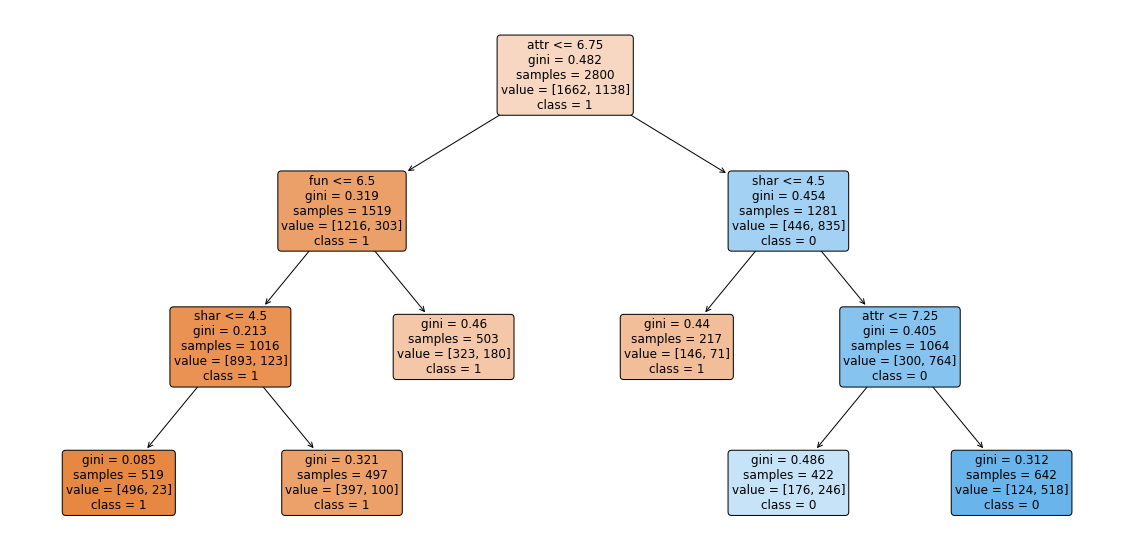

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# 预处理数据以适应决策树模型
label_encoders = {}
for column in csv_data.columns:
    if csv_data[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        csv_data[column] = label_encoders[column].fit_transform(csv_data[column])

# 仅使用后九列和 age, income, career 作为自变量
selected_columns = ['age', 'income', 'goal', 'career', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'met']
X = csv_data[selected_columns]
y = csv_data['dec']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练决策树模型
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 进行剪枝，寻找最优的ccp_alpha参数
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha > 0:  # 过滤掉非正值
        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)

# 找到最佳的ccp_alpha
alpha_scores = [cross_val_score(clf, X_train, y_train, cv=5).mean() for clf in clfs]
best_alpha = ccp_alphas[np.argmax(alpha_scores)]

# 使用最佳的ccp_alpha重新训练模型
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

# 评估剪枝后的模型性能
y_pred = pruned_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# 绘制剪枝后的决策树图像
plt.figure(figsize=(20,10))
plot_tree(pruned_clf, feature_names=X.columns, class_names=y.unique().astype(str), filled=True, rounded=True, fontsize=12)
plt.savefig('../output/pruned_decision_tree.png')
plt.show()

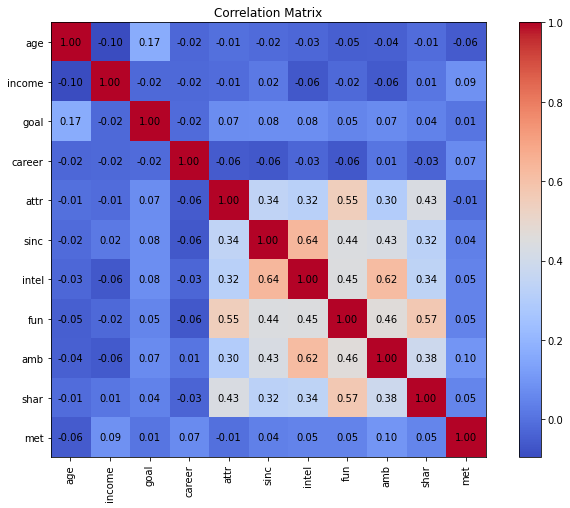

In [3]:
# 计算相关性矩阵
correlation_matrix = X.corr(method='spearman')

# 绘制相关性矩阵热图
plt.figure(figsize=(12, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()

# 添加标签
plt.xticks(range(len(selected_columns)), selected_columns, rotation=90)
plt.yticks(range(len(selected_columns)), selected_columns)

# 在每个单元格中添加相关系数值
for i in range(len(selected_columns)):
    for j in range(len(selected_columns)):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')

plt.title('Correlation Matrix')
plt.savefig('../output/correlation_matrix.png')
plt.show()

In [11]:
# 用 like 代替六项得分
selected_columns = ['age', 'income', 'goal', 'career', 'like', 'met']
X = csv_data[selected_columns]
y = csv_data['dec']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练决策树模型
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 进行剪枝，寻找最优的ccp_alpha参数
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
clfs = []
for ccp_alpha in ccp_alphas:
    if ccp_alpha > 0:  # 过滤掉非正值
        clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)

# 找到最佳的ccp_alpha
alpha_scores = [cross_val_score(clf, X_train, y_train, cv=5).mean() for clf in clfs]
best_alpha = ccp_alphas[np.argmax(alpha_scores)]

# 使用最佳的ccp_alpha重新训练模型
pruned_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_clf.fit(X_train, y_train)

# 评估剪枝后的模型性能
y_pred = pruned_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.8002853067047075
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       422
           1       0.75      0.74      0.75       279

    accuracy                           0.80       701
   macro avg       0.79      0.79      0.79       701
weighted avg       0.80      0.80      0.80       701



### Part 2. 梯度提升树

Accuracy: 0.6533523537803139
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.86      0.75       422
           1       0.61      0.35      0.44       279

    accuracy                           0.65       701
   macro avg       0.64      0.60      0.60       701
weighted avg       0.64      0.65      0.63       701



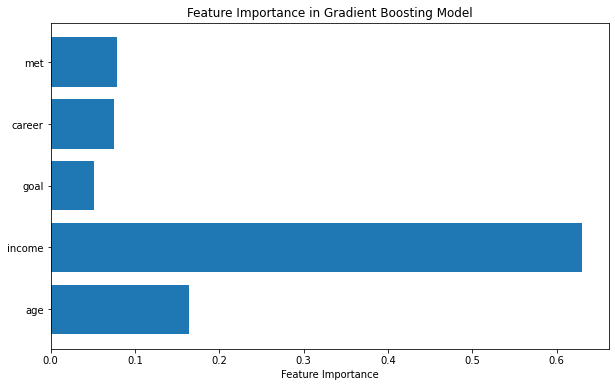

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

# 训练GradientBoosting模型
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# 评估模型性能
y_pred = gb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# 可视化特征重要性
feature_importances = gb_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting Model')
plt.savefig('../output/feature_importance.png')
plt.show()